In [20]:
import cooler
import numpy as np
import pandas as pd
import glob, os
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.patches import Rectangle
from copy import copy

In [70]:

# from hmmlearn import hmm
from scipy.stats import zscore
# from scipy.stats import pearsonr
from matplotlib.colors import BoundaryNorm
from sklearn.cluster import KMeans

In [3]:
ls /home/venevs/DOTS_TESTING/rao_compartments

Rao2014-GM12878-MboI-allreps-filtered.100kb.cool
Rao2014-GM12878-MboI-allreps-filtered.1mb.cool


In [4]:
path = "/home/venevs/DOTS_TESTING/rao_compartments/Rao2014-GM12878-MboI-allreps-filtered.1mb.cool"

clr = cooler.Cooler(path)

### Just trying to see if the data looks the way we expect ...

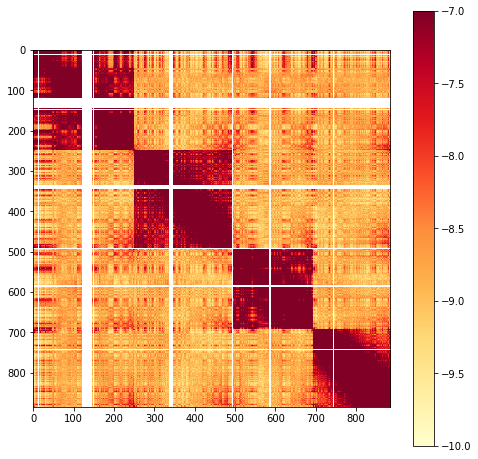

In [72]:
idx = clr.offset('chr5')

img = plt.imshow(np.log(clr.matrix()[:idx,:idx]),cmap='YlOrRd',vmin=-10,vmax=-7)
plt.colorbar(img)

fig = plt.gcf()
fig.set_size_inches(8,8)
# plt.colorbar(img)

### Let's try to play with a small subset of chromosomes , just to better understand what is going on ...

In [66]:
odd_chroms=clr.chromnames[:-10:2]
even_chroms=clr.chromnames[1:-10:2]
print(odd_chroms)
print(even_chroms)

['chr1', 'chr3', 'chr5', 'chr7', 'chr9', 'chr11', 'chr13', 'chr15']
['chr2', 'chr4', 'chr6', 'chr8', 'chr10', 'chr12', 'chr14']


In [63]:
# Preparing some outline boxes around each piece of trans-heatmap:

def get_len(extent):
    _1,_2 = extent
    return _2-_1

def get_patches(odd_chroms,even_chroms,clr):
    kwargs = {"alpha":1,"facecolor":'none',"edgecolor":'blue',"linewidth":2}
    x,y = 0,0
    patches = []
    for odd_chr in odd_chroms:
        y = 0
        for even_chr in even_chroms:
            h = get_len(clr.extent(even_chr))
            w = get_len(clr.extent(odd_chr))
            patches.append(Rectangle((x,y), w, h, **kwargs))
            y += h
        x += w
    return patches

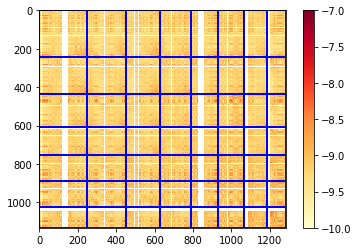

In [67]:
even_list=[]
for odd_chr in odd_chroms:
    odd_list=[]
    for even_chr in even_chroms:
        chr_split=clr.matrix(balance=True).fetch(even_chr,odd_chr)
        odd_list.append(chr_split)
    odd_concat=np.concatenate(odd_list,axis=0)
    even_list.append(odd_concat)
even_odd=np.concatenate(even_list,axis=1)
# modify that with savetx
plt.imshow(np.log(even_odd),cmap='YlOrRd')#,vmin=-10,vmax=-7)

patches = get_patches(odd_chroms,even_chroms,clr)
# from matplotlib.patches import Rectangle
ax = plt.gca()
for p in patches:
    ax.add_patch(p)

plt.colorbar(img)

### Now the same but trying to normalize each pair of trans data ...

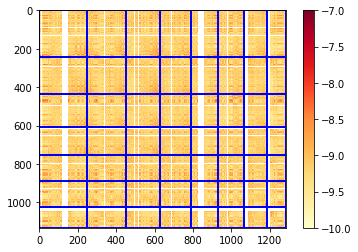

In [68]:
even_list=[]
for odd_chr in odd_chroms:
    odd_list=[]
    for even_chr in even_chroms:
        chr_split=clr.matrix(balance=True).fetch(even_chr,odd_chr)
        chr_split = chr_split/np.nanmean(chr_split)
        odd_list.append(chr_split)
    odd_concat=np.concatenate(odd_list,axis=0)
    even_list.append(odd_concat)
even_odd=np.concatenate(even_list,axis=1)
# modify that with savetx
plt.imshow(np.log(even_odd),cmap='YlOrRd')#,vmin=-10,vmax=-7)

patches = get_patches(odd_chroms,even_chroms,clr)
# from matplotlib.patches import Rectangle
ax = plt.gca()
for p in patches:
    ax.add_patch(p)

plt.colorbar(img)

### Let's try clustering right here ...

In [75]:
A = even_odd
A = np.array(A)
A[~np.isfinite(A)] = 0

In [76]:
mask_col=np.nansum(A,axis=0)>0
mask_row=np.nansum(A,axis=1)>0

print(mask_row.sum())
print(mask_col.sum())
print(mask_row.shape)
print(mask_col)

1078
1151
(1133,)
[False  True  True ...  True  True  True]


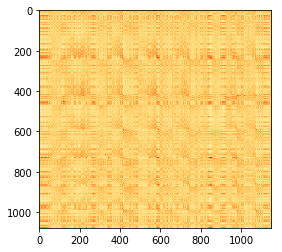

In [164]:
A=A[:,mask_col][mask_row,:]
A_log=np.log(A)
plt.imshow(A_log,cmap='YlOrRd')#,vmin=-10,vmax=-7)

### Let's fill `log(0)` ones with `0` for now at least

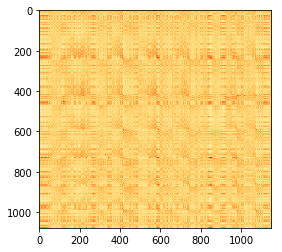

In [84]:
A_log[np.isinf(A_log)] = 0
A_log[np.isnan(A_log)] = 0
plt.imshow(A_log,cmap='YlOrRd')#,vmin=-10,vmax=-7)

In [85]:
A_zscore_row=zscore(A_log,axis=0)
A_log_T=A_log.T
A_zscore_col=zscore(A_log_T,axis=0)


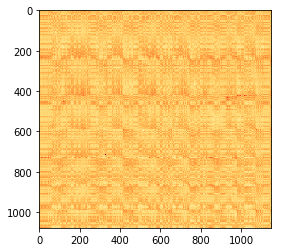

In [87]:
plt.imshow(A_zscore_row,cmap='YlOrRd')#,vmin=-10,vmax=-7)

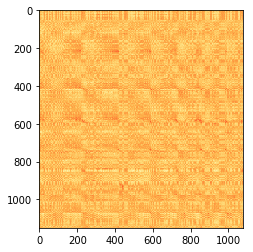

In [86]:
plt.imshow(A_zscore_col,cmap='YlOrRd')#,vmin=-10,vmax=-7)

In [177]:
kmeans_clust_row = KMeans(n_clusters=3, random_state=0).fit(A_zscore_row)

sizes of the clusters ...
[438 345 295]


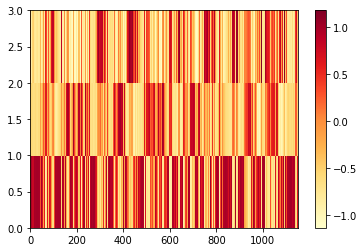

In [178]:
_ = plt.pcolormesh(kmeans_clust_row.cluster_centers_,cmap=plt.get_cmap("YlOrRd"))
plt.colorbar(_)
print("sizes of the clusters ...")
print(np.bincount(kmeans_clust_row.labels_))


In [179]:
kmeans_clust_col = KMeans(n_clusters=3, random_state=0).fit(A_zscore_col)

sizes of the clusters ...
[534 356 261]


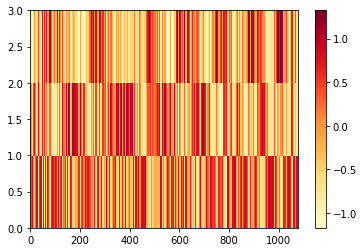

In [180]:
_ = plt.pcolormesh(kmeans_clust_col.cluster_centers_,cmap=plt.get_cmap("YlOrRd"))
plt.colorbar(_)
print("sizes of the clusters ...")
print(np.bincount(kmeans_clust_col.labels_))


In [181]:
def quantify_cluster_interacions(A, row_labels, col_labels):
    # finish yourslef by doing np.unique of something like that
    number_of_unique_row_labels = np.unique(row_labels)
    number_of_unique_col_labels = np.unique(col_labels)
    print(number_of_unique_row_labels)
    print(number_of_unique_col_labels)

    # output array of mean-interactions for each pairs of clusters ...
    S = np.zeros((len(number_of_unique_row_labels),len(number_of_unique_col_labels)))

    for i in range(len(number_of_unique_row_labels)):
        row_mask = (row_labels == i)
        print(row_labels.shape)
        for j in range(len(number_of_unique_col_labels)):
            col_mask = (col_labels == j)
            print(col_labels.shape)
            # saddle-plot style
            # extracting interaction values
            # corresponding to row_cluster i
            # and col_cluster j:
            print(A.shape)
            data = A[row_mask, :][:, col_mask]
            #data = A[:, row_mask][col_mask, :]
            # data = data[np.isfinite(data)]
            S[i, j] += np.nanmean(data)

    return S

In [182]:
ff=quantify_cluster_interacions(A_log, kmeans_clust_row.labels_, kmeans_clust_col.labels_)
print(ff)
import random

[0 1 2]
[0 1 2]
(1078,)
(1151,)
(1078, 1151)
(1151,)
(1078, 1151)
(1151,)
(1078, 1151)
(1078,)
(1151,)
(1078, 1151)
(1151,)
(1078, 1151)
(1151,)
(1078, 1151)
(1078,)
(1151,)
(1078, 1151)
(1151,)
(1078, 1151)
(1151,)
(1078, 1151)
[[ 0.33247014 -0.18720646 -0.17681328]
 [-0.2072424   0.0336136  -0.20580819]
 [-0.27053344 -0.12846013  0.03717932]]


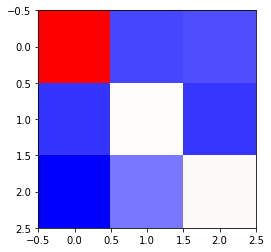

In [183]:
plt.imshow(ff,cmap='bwr')

In [175]:
def get_checker(shape,set_of_xy,alpha,the_cmap='Blues'):
    """
    describe it

    Parameters
    ----------
    shape : tuple
        A tuple describing the shape of the output checkerboard mask
    set_of_xy : array_of_tuples
        Where in each tuple we would have a pair of index lists to
        be intersected.
    alpha : scalar
        transparency for the areas corresponding to intersected indices
        or in other words in the area we want to highlight
    the_cmap : string
        name of the matplotlib cmap to be used for highlighting desired
        areas of the heatmap

    Returns
    -------
    checker : image
        A proper RGB image with alphas channel set such that the
        highlighted areas are alpha-transparent, and non-highlighted
        ones are fully transparent.

    """
    # add some check here ...
    # ...
    # THIS IS HOW WE MAKE A CHECKERBOARD MASK ON TOP OF HEATMAP-SLICE:
    checker = np.zeros(shape)
    # combine all of the areas we'd like ot highlight
    for x,y in set_of_xy:
        xv,yv = np.meshgrid(x,y)
        checker[xv,yv] += 1
    # define transparency, by clipping non-zero values,
    # i.e. the ones that we'd like to highlight to the desired
    # alpha level
    alphas = np.clip(checker,0,alpha)
    # cmap of choice ...
    cmap = plt.cm.get_cmap(the_cmap)
    # checker is already normalized between 0 and 1
    # so, just turn into RGB:
    checker = cmap(checker)
    # blend in an alpha chanel:
    checker[...,-1] = alphas
    return checker

In [176]:
# to be continued with more validation ...

# # observed time-course:
# print(chrom)


# gs = plt.GridSpec(nrows=3, ncols=8)
# plt.figure(figsize=(30, 15)) #width, height

# opts = dict(
# #     vmin=0,
# #     vmax=1000,
#     cmap='YlOrBr')


# coars_factor = 4
# coars_dict = {0:coars_factor,1:coars_factor}
# # tcs_coarsed = {tp:numutils.coarsen(np.sum, tcs[tp].values, coars_dict) for tp in tcs}


# for i,tp in enumerate(tcs_ordered_keys):
#     ax = plt.subplot(gs[i])
#     matrix = tcs_dict[chrom][tp][centro_idx:,centro_idx:]
#     matrix_coarsed = numutils.coarsen(np.sum, matrix,coars_dict,trim_excess=True)
#     #
#     checker = get_checker(matrix.shape,
#                           [(lads_for_saddle.nonzero(),lads_for_saddle.nonzero()),],
#                           0.2,
#                           the_cmap='winter_r')
#     checker_coarsed = numutils.coarsen(np.mean, checker,coars_dict,trim_excess=True)
#     img = ax.matshow(
#         np.log(matrix_coarsed),  
#         **opts)
#     #
#     ax.matshow(checker_coarsed)
#     #
#     ax.xaxis.tick_bottom()
#     if i > 0:
#         ax.yaxis.set_visible(False)
#     plt.title(tp)

    
# # plt.show()